In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
csv_file_path = '/content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv'
image_directory = '/content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img'
image_size = (224, 224)

In [38]:
df = pd.read_csv(csv_file_path)
df['Filename'] = df['Filename'].apply(lambda x: " ".join(x.split()))

In [39]:
def load_and_preprocess_image(image_filename):
    img_path = os.path.join(image_directory, image_filename)
    print(f"Loading image from path: {img_path}")
    img = load_img(img_path, target_size=image_size)
    img = img_to_array(img) / 255.0
    return img.astype('float32')

In [7]:
images = np.array([load_and_preprocess_image(img_filename) for img_filename in df['Filename'].values])

Streaming output truncated to the last 5000 lines.
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-161.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1617.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1625.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1633.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10

In [40]:
df['O3'] = df['O3'].fillna(df['O3'].mean())
df['NO2'] = df['NO2'].fillna(df['NO2'].mean())
df.dropna(subset=['O3', 'NO2'], inplace=True)

In [41]:
aqi_values = np.array(df['AQI'].values).astype('float32')
pm25_values = np.array(df['PM2.5'].values).astype('float32')
pm10_values = np.array(df['PM10'].values).astype('float32')
O3_values = np.array(df['O3'].values).astype('float32')
NO2_values = np.array(df['NO2'].values).astype('float32')

In [42]:
aqi_values = np.clip(aqi_values, 0, 500)
pm25_values = np.clip(pm25_values, 0, 500)
pm10_values = np.clip(pm10_values, 0, 500)
O3_values = np.clip(O3_values, 0, 300)
NO2_values = np.clip(NO2_values, 0, 200)

In [43]:
print(f"Images shape: {images.shape}")
print(f"AQI values shape: {aqi_values.shape}")
print(f"PM2.5 values shape: {pm25_values.shape}")
print(f"PM10 values shape: {pm10_values.shape}")
print(f"O3 values shape: {O3_values.shape}")
print(f"NO2 values shape: {NO2_values.shape}")

Images shape: (12240, 224, 224, 3)
AQI values shape: (12240,)
PM2.5 values shape: (12240,)
PM10 values shape: (12240,)
O3 values shape: (12240,)
NO2 values shape: (12240,)


In [44]:
X_train, X_val, Y_train_aqi, Y_val_aqi, Y_train_pm25, Y_val_pm25, Y_train_pm10, Y_val_pm10, Y_train_O3, Y_val_O3, Y_train_NO2, Y_val_NO2 = train_test_split(
    images, aqi_values, pm25_values, pm10_values, O3_values, NO2_values, test_size=0.2, random_state=42
)

In [45]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train_aqi shape: {Y_train_aqi.shape}")
print(f"Y_val_aqi shape: {Y_val_aqi.shape}")
print(f"Y_train_pm25 shape: {Y_train_pm25.shape}")
print(f"Y_val_pm25 shape: {Y_val_pm25.shape}")
print(f"Y_train_pm10 shape: {Y_train_pm10.shape}")
print(f"Y_val_pm10 shape: {Y_val_pm10.shape}")
print(f"Y_train_O3 shape: {Y_train_O3.shape}")
print(f"Y_val_O3 shape: {Y_val_O3.shape}")
print(f"Y_train_NO2 shape: {Y_train_NO2.shape}")
print(f"Y_val_NO2 shape: {Y_val_NO2.shape}")

X_train shape: (9792, 224, 224, 3)
X_val shape: (2448, 224, 224, 3)
Y_train_aqi shape: (9792,)
Y_val_aqi shape: (2448,)
Y_train_pm25 shape: (9792,)
Y_val_pm25 shape: (2448,)
Y_train_pm10 shape: (9792,)
Y_val_pm10 shape: (2448,)
Y_train_O3 shape: (9792,)
Y_val_O3 shape: (2448,)
Y_train_NO2 shape: (9792,)
Y_val_NO2 shape: (2448,)


In [46]:
# Define the LeakyReLU activation
leaky_relu = tf.keras.layers.LeakyReLU()

# Input Layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Block 1: Two CNN layers with 64 filters and one MaxPooling layer
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(input_layer)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), padding='same')(x)

# Block 2: Two CNN layers with 128 filters and one MaxPooling layer
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Block 3: Residual block with one CNN layer (128 filters)
residual_1 = x  # Save for residual connection
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_1])  # Residual connection
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Block 4: Residual block with one CNN layer (128 filters)
residual_2 = x
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_2])
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Block 5: Residual block with one CNN layer (128 filters)
residual_3 = x
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_3])
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Flatten the output for fully connected layers
x = tf.keras.layers.Flatten()(x)

# Fully connected layers (256 and 128 neurons with LeakyReLU activation)
x = tf.keras.layers.Dense(256, activation=leaky_relu)(x)
x = tf.keras.layers.Dense(128, activation=leaky_relu)(x)

# Output layers for AQI, PM2.5, PM10, NO2, and O3
output_aqi = tf.keras.layers.Dense(1, activation='linear', name='AQI')(x)
output_pm25 = tf.keras.layers.Dense(1, activation='linear', name='PM2_5')(x)
output_pm10 = tf.keras.layers.Dense(1, activation='linear', name='PM10')(x)
output_O3 = tf.keras.layers.Dense(1, activation='linear', name='O3')(x)
output_NO2 = tf.keras.layers.Dense(1, activation='linear', name='NO2')(x)

# Define the model with inputs and outputs
model = tf.keras.Model(inputs=input_layer, outputs=[output_aqi, output_pm25, output_pm10, output_O3, output_NO2])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')


# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 75, 75, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 75, 75, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 38, 38, 128)    │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 38, 38, 128)    │        147,584 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 38, 38, 128)    │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 19, 19, 128)    │              0 │ add_3[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 19, 19, 128)    │        147,584 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 19, 19, 128)    │              0 │ conv2d_12[0][0],       │
│                           │                        │                │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 10, 10, 128)    │              0 │ add_4[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 10, 10, 128)    │        147,584 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 10, 10, 128)    │              0 │ conv2d_13[0][0],       │
│                           │                        │                │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9      

 Total params: 1,555,909 (5.94 MB)

 Trainable params: 1,555,909 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
weight_path = "/content/drive/MyDrive/Air_Pollution_Image_Dataset/aqi_model.weights.h5"

callback = [
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    mode='min',
    restore_best_weights=True
)

In [95]:
checkpoint_path = "best_model.keras"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

In [96]:
batch_size = 16
epochs = 150

history = model.fit(
    X_train,
    {'AQI': Y_train_aqi, 'PM2_5': Y_train_pm25, 'PM10': Y_train_pm10, 'O3': Y_train_O3, 'NO2': Y_train_NO2,},
    validation_data=(X_val, {'AQI': Y_val_aqi, 'PM2_5': Y_val_pm25, 'PM10': Y_val_pm10, 'O3': Y_val_O3, 'NO2': Y_val_NO2}),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1
)

model.save('final_model.keras')

Epoch 1/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 581.3715 - val_loss: 1835.8948
Epoch 2/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 498.3941 - val_loss: 1818.5500
Epoch 3/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 418.3668 - val_loss: 1799.3253
Epoch 4/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 438.8755 - val_loss: 1810.1484
Epoch 5/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 424.4857 - val_loss: 1799.7590
Epoch 6/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 446.0482 - val_loss: 1878.1718
Epoch 7/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 517.5735 - val_loss: 1868.4109
Epoch 8/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 405.5134 - val_loss: 2054.0601
Epoch 9/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 463.4816 - val_loss: 1770.6447
Epoch 10/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 444.5875 - val_loss: 1765.2566
Epoch 11/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - l

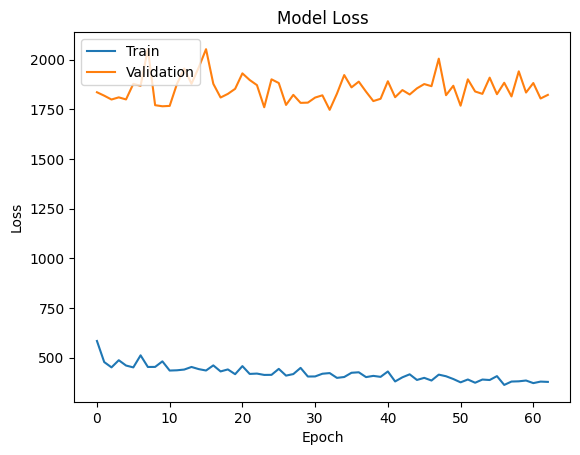

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [98]:
x_origin_test = X_val
y_test = np.column_stack((Y_val_aqi, Y_val_pm25, Y_val_pm10, Y_val_O3, Y_val_NO2))

In [99]:
weight_path = '/content/final_model.keras'
model.load_weights(weight_path)

loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is:', loss ** 0.5)

y_predict_aqi, y_predict_pm25, y_predict_pm10, y_predict_O3 , y_predict_NO2 = model.predict(x_origin_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12429.3672
RMSE is: 111.8385808389149
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [100]:
def classify_values(values, pollutant_type):
    categories = np.zeros(len(values))

    for i in range(len(values)):
        if pollutant_type == 'AQI':
            if values[i] <= 50:
                categories[i] = 0  # Good
            elif 51 <= values[i] <= 100:
                categories[i] = 1  # Moderate
            elif 101 <= values[i] <= 150:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 151 <= values[i] <= 200:
                categories[i] = 3  # Unhealthy
            elif 201 <= values[i] <= 300:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'PM2.5':
            if values[i] <= 12.0:
                categories[i] = 0  # Good
            elif 12.1 <= values[i] <= 35.4:
                categories[i] = 1  # Moderate
            elif 35.5 <= values[i] <= 55.4:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 55.5 <= values[i] <= 150.4:
                categories[i] = 3  # Unhealthy
            elif 150.5 <= values[i] <= 250.4:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'PM10':
            if values[i] <= 54:
                categories[i] = 0  # Good
            elif 55 <= values[i] <= 154:
                categories[i] = 1  # Moderate
            elif 155 <= values[i] <= 254:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 255 <= values[i] <= 354:
                categories[i] = 3  # Unhealthy
            elif 355 <= values[i] <= 424:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'O3':
            if values[i] <= 54:
                categories[i] = 0  # Good
            elif 55 <= values[i] <= 70:
                categories[i] = 1  # Moderate
            elif 71 <= values[i] <= 85:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 86 <= values[i] <= 105:
                categories[i] = 3  # Unhealthy
            elif 106 <= values[i] <= 200:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'NO2':
            if values[i] <= 53:
                categories[i] = 0  # Good
            elif 54 <= values[i] <= 100:
                categories[i] = 1  # Moderate
            elif 101 <= values[i] <= 360:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 361 <= values[i] <= 649:
                categories[i] = 3  # Unhealthy
            elif 650 <= values[i] <= 1249:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe
        else:
            raise ValueError("Unknown pollutant type")

    return categories.astype(int)

In [101]:
y_predict_aqi_cat = classify_values(y_predict_aqi, 'AQI')
y_predict_pm25_cat = classify_values(y_predict_pm25, 'PM2.5')
y_predict_pm10_cat = classify_values(y_predict_pm10, 'PM10')
y_predict_O3_cat = classify_values(y_predict_O3, 'O3')
y_predict_NO2_cat = classify_values(y_predict_NO2, 'NO2')

In [102]:
y_test_aqi_cat = classify_values(y_test[:, 0], 'AQI')
y_test_pm25_cat = classify_values(y_test[:, 1], 'PM2.5')
y_test_pm10_cat = classify_values(y_test[:, 2], 'PM10')
y_test_O3_cat = classify_values(y_test[:, 3], 'O3')
y_test_NO2_cat = classify_values(y_test[:, 4], 'NO2')

In [103]:
precision_aqi = precision_score(y_test_aqi_cat, y_predict_aqi_cat, average='macro')
recall_aqi = recall_score(y_test_aqi_cat, y_predict_aqi_cat, average='macro')

precision_pm25 = precision_score(y_test_pm25_cat, y_predict_pm25_cat, average='macro')
recall_pm25 = recall_score(y_test_pm25_cat, y_predict_pm25_cat, average='macro')

precision_pm10 = precision_score(y_test_pm10_cat, y_predict_pm10_cat, average='macro')
recall_pm10 = recall_score(y_test_pm10_cat, y_predict_pm10_cat, average='macro')

precision_O3 = precision_score(y_test_O3_cat, y_predict_O3_cat, average='macro')
recall_O3 = recall_score(y_test_O3_cat, y_predict_O3_cat, average='macro')

precision_NO2 = precision_score(y_test_NO2_cat, y_predict_NO2_cat, average='macro')
recall_NO2 = recall_score(y_test_NO2_cat, y_predict_NO2_cat, average='macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [104]:
print(f'AQI Precision: {precision_aqi}')
print(f'PM2.5 Precision: {precision_pm25}')
print(f'PM10 Precision: {precision_pm10}')
print(f'O3 Precision: {precision_O3}')
print(f'NO2 Precision: {precision_NO2}')

AQI Precision: 0.8260276608876377
PM2.5 Precision: 0.7473348243247528
PM10 Precision: 0.8454638913566268
O3 Precision: 0.7427733132278588
NO2 Precision: 0.6735050242814264


In [105]:
print(f'AQI Recall: {recall_aqi}')
print(f'PM2.5 Recall: {recall_pm25}')
print(f'PM10 Recall: {recall_pm10}')
print(f'O3 Recall: {recall_O3}')
print(f'NO2 Recall: {recall_NO2}')

AQI Recall: 0.8273831920488611
PM2.5 Recall: 0.8698607636860768
PM10 Recall: 0.8430247738254462
O3 Recall: 0.794641166718269
NO2 Recall: 0.6541467210000259


In [106]:
def calculate_accuracy(y_true, y_pred):
    t = np.sum(y_true == y_pred)
    n = len(y_true) - t
    acc = t / len(y_true)
    return acc, t, n

In [107]:
acc_aqi, t_aqi, n_aqi = calculate_accuracy(y_test_aqi_cat, y_predict_aqi_cat)
acc_pm25, t_pm25, n_pm25 = calculate_accuracy(y_test_pm25_cat, y_predict_pm25_cat)
acc_pm10, t_pm10, n_pm10 = calculate_accuracy(y_test_pm10_cat, y_predict_pm10_cat)
acc_O3, t_O3, n_O3 = calculate_accuracy(y_test_O3_cat, y_predict_O3_cat)
acc_NO2, t_NO2, n_NO2 = calculate_accuracy(y_test_NO2_cat, y_predict_NO2_cat)

print(f'AQI Classification Accuracy: {acc_aqi}, True: {t_aqi}, False: {n_aqi}')
print(f'PM2.5 Classification Accuracy: {acc_pm25}, True: {t_pm25}, False: {n_pm25}')
print(f'PM10 Classification Accuracy: {acc_pm10}, True: {t_pm10}, False: {n_pm10}')
print(f'O3 Classification Accuracy: {acc_O3}, True: {t_O3}, False: {n_O3}')
print(f'NO2 Classification Accuracy: {acc_NO2}, True: {t_NO2}, False: {n_NO2}')

AQI Classification Accuracy: 0.8243464052287581, True: 2018, False: 430
PM2.5 Classification Accuracy: 0.8733660130718954, True: 2138, False: 310
PM10 Classification Accuracy: 0.8884803921568627, True: 2175, False: 273
O3 Classification Accuracy: 0.9060457516339869, True: 2218, False: 230
NO2 Classification Accuracy: 0.9358660130718954, True: 2291, False: 157


In [108]:
f1_aqi = f1_score(y_test_aqi_cat, y_predict_aqi_cat, average='macro')
f1_pm25 = f1_score(y_test_pm25_cat, y_predict_pm25_cat, average='macro')
f1_pm10 = f1_score(y_test_pm10_cat, y_predict_pm10_cat, average='macro')
f1_O3 = f1_score(y_test_O3_cat, y_predict_O3_cat, average='macro')
f1_NO2 = f1_score(y_test_NO2_cat, y_predict_NO2_cat, average='macro')

print(f'F1 Score for AQI: {f1_aqi}')
print(f'F1 Score for PM2.5: {f1_pm25}')
print(f'F1 Score for PM10: {f1_pm10}')
print(f'F1 Score for O3: {f1_O3}')
print(f'F1 Score for NO2: {f1_NO2}')

F1 Score for AQI: 0.8210213937109784
F1 Score for PM2.5: 0.765454854118547
F1 Score for PM10: 0.8397983358958868
F1 Score for O3: 0.7465553421114052
F1 Score for NO2: 0.6629055401527312


In [109]:
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    confusion_mtx = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    f, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.5, cmap=cmap, linecolor="gray", fmt='.1f', ax=ax,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

aqi_cmap = "Blues"
pm25_cmap = "Greens"
pm10_cmap = "Reds"
NO2_cmap = "Purples"
O3_cmap = "Oranges"

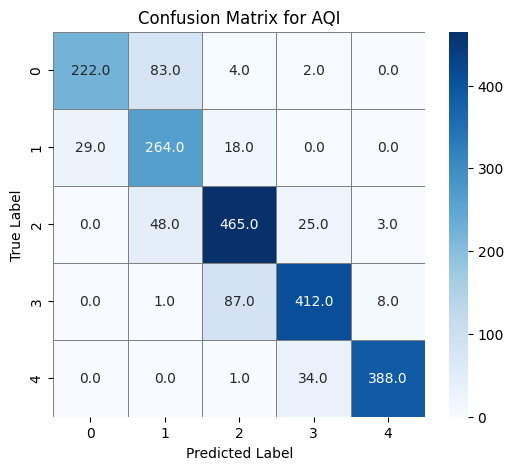

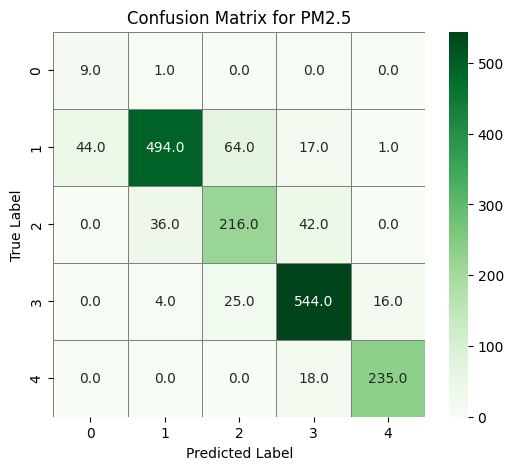

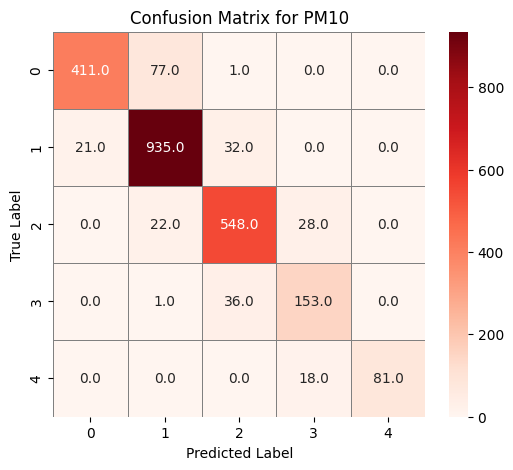

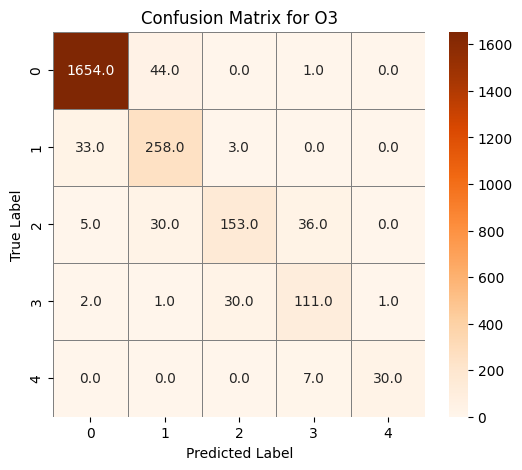

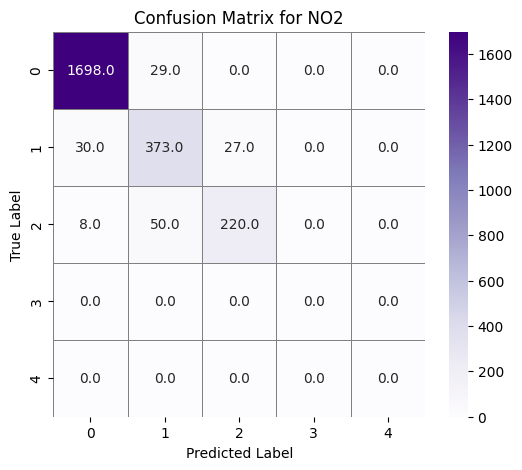

In [110]:
plot_confusion_matrix(y_test_aqi_cat, y_predict_aqi_cat, "AQI", aqi_cmap)
plot_confusion_matrix(y_test_pm25_cat, y_predict_pm25_cat, "PM2.5", pm25_cmap)
plot_confusion_matrix(y_test_pm10_cat, y_predict_pm10_cat, "PM10", pm10_cmap)
plot_confusion_matrix(y_test_O3_cat, y_predict_O3_cat, "O3", O3_cmap)
plot_confusion_matrix(y_test_NO2_cat, y_predict_NO2_cat, "NO2", NO2_cmap)